<a href="https://colab.research.google.com/github/khakhiD/ML/blob/main/car_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 90% 101M/112M [00:00<00:00, 172MB/s] 
100% 112M/112M [00:00<00:00, 178MB/s]


In [5]:
!unzip /content/car-object-detection.zip

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [2]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Total 12173 (delta 0), reused 0 (delta 0), pack-reused 12173
Receiving objects: 100% (12173/12173), 11.96 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (8428/8428), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.3 MB/s 
CPU times: user 211 ms, sys: 64.3 ms, total: 275 ms
Wall time: 9.72 s


**Loading Data / Preprocessing**

In [6]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [8]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_11900


(380, 676, 3)

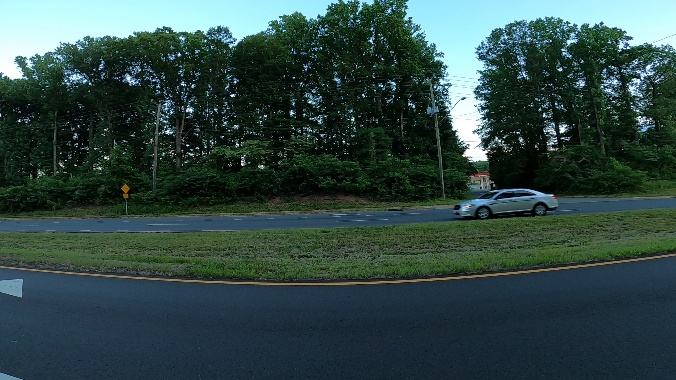

In [9]:
image = random.choice(index)
Image(filename=f'/content/data/training_images/{image}.jpg',width=600)

In [13]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:
#!python train.py --batch 2 --epochs 1 --data /content/data~../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new

In [14]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/content/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CPU

100% 14.1M/14.1M [00:00<00:00, 118MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/175 /content/data/testing_images/vid_5_25100.jpg: 416x704 Done. (0.315s)
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 416x704 Done. (0.289s)
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 416x704 Done. (0.319s)
image 4/175 /content/data/testing_images/vid_5_25160.jpg: 416x704 Done. (0.530s)
image 5/175 /content

In [ ]:
!ls /gdrive/MyDrive/Colab Notebooks/

In [15]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("runs/detect/exp"):
    predicted_files.extend(filenames)

In [17]:
Image(filename=f'/content/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

IndexError: ignored